<font size="+3"><strong>Predicting Damage with Logistic Regression</strong></font>

In [4]:
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted


# Prepare Data

## Import 

In [36]:
def wrangle(db_path):
    # Connect to database
    conn = sql.connect(db_path)

    # Construct query
    query = """
            SELECT s.* ,d.damage_grade
            FROM building_structure as s 
            JOIN building_damage AS d
            ON s.building_id = d.building_id
            WHERE s.district_id=36
            """

    # Read query results into DataFrame
    df = pd.read_sql(query,conn,"building_id")
    
    # identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # create binary target
    df["damage_grade"]= df["damage_grade"].str[-1].astype(int)
    df["severe_damage"]=(df["damage_grade"]>3).astype(int)
    
    # Drop unnecessary features 
    drop_cols.append("technical_solution_proposed")
    
    # drop old target
    drop_cols.append("damage_grade")
    
    # drop multicollinearty columns
    drop_cols.append("count_floors_pre_eq")
    
    # drop haigh cardinality
    drop_cols.extend(["district_id","vdcmun_id","ward_id"])
    
    # drop leaky columns 
    df.drop(columns=drop_cols , inplace=True)
    
    return df

**Task 4.2.1:** use the `wrangle` function above so that the it returns the results of `query` as a DataFrame. Be sure that the index column is set to `"building_id"`. Also, the path to the SQLite database is `"data/nepal.db"`.

In [37]:
df = wrangle("data/nepal.db")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,...,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,severe_damage
building_id,,,,,,,,,,,,,,,,,,,,,
360101000011,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
360101000021,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,0
360101000031,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,0
360101000041,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,0,0,0,0,0,0,0,0,0,1
360101000051,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,...,0,0,0,0,0,0,0,0,0,1


There seem to be several features in `df` with information about the condition of a property after the earthquake.

**Task 4.2.2:** Add to your wrangle function so that these features are dropped from the DataFrame. Don't forget to rerun all the cells above. 


In [8]:
# drop_cols =[]
# for col in df.columns:
#     if "post_eq" in col:
#         drop_cols.append(col)
# drop_cols        
# drop_cols = [col for col in df.columns if "post_eq" in col]
# drop_cols

['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [38]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78074 entries, 360101000011 to 366709001281
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   age_building                            78074 non-null  int64 
 1   plinth_area_sq_ft                       78074 non-null  int64 
 2   height_ft_pre_eq                        78074 non-null  int64 
 3   land_surface_condition                  78074 non-null  object
 4   foundation_type                         78074 non-null  object
 5   roof_type                               78074 non-null  object
 6   ground_floor_type                       78074 non-null  object
 7   other_floor_type                        78074 non-null  object
 8   position                                78074 non-null  object
 9   plan_configuration                      78074 non-null  object
 10  has_superstructure_adobe_mud            78074 non-nu

We want to build a **binary classification** model, but our current target `"damage_grade"` has more than two categories.

**Task 4.2.3:** Add to your wrangle function so that it creates a new target column `"severe_damage"`. For buildings where the `"damage_grade"` is Grade 4 or above, `"severe_damage"` should be `1`. For all other buildings, `"severe_damage"` should be `0`. Don't forget to drop `"damage_grade"` to avoid leakage, and rerun all the cells above.


In [20]:
# df["damage_grade"]= df["damage_grade"].str[-1].astype(int)
# df["severe_damage"]=(df["damage_grade"]>3)
# df["severe_damage"]=(df["damage_grade"]>3).astype(int)
# df["severe_damage"]

## Explore

Since our model will be a type of linear model, we need to make sure there's no issue with multicollinearity in our dataset.

**Task 4.2.4:** Plot a correlation heatmap of the remaining numerical features in `df`. Since `"severe_damage"` will be your target, you don't need to include it in your heatmap. 
​

In [23]:
df["severe_damage"].corr(df["count_floors_pre_eq"])

0.009728806263020353

In [24]:
df["severe_damage"].corr(df["height_ft_pre_eq"])

-0.03858480093179795

<AxesSubplot:>

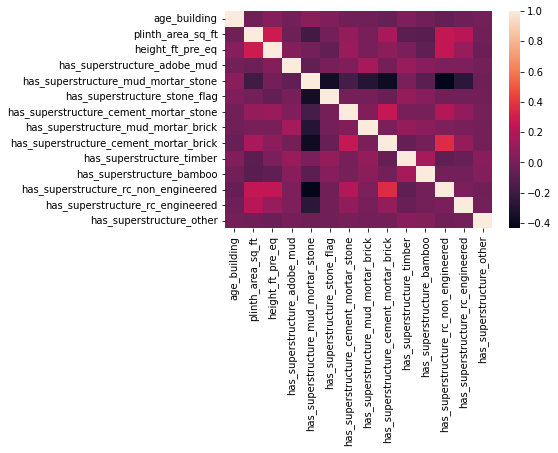

In [39]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()
# Plot heatmap of `correlation`
sns.heatmap(correlation)

**Task 4.2.5:** So we will change `wrangle` function so that it drops the `"count_floors_pre_eq"` column. 

Before we build our model, let's see if we can identify any obvious differences between houses that were severely damaged in the earthquake (`"severe_damage"==1`) those that were not (`"severe_damage"==0`). Let's start with a numerical feature. 

**Task 4.2.6:** Use seaborn to create a boxplot that shows the distributions of the `"height_ft_pre_eq"` column for both groups in the `"severe_damage"` column. Remember to label your axes. 


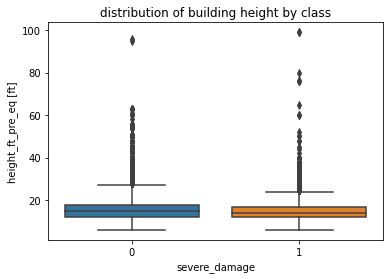

In [40]:
# Create boxplot
sns.boxplot(x="severe_damage",y="height_ft_pre_eq",data=df)
# Label axes
plt.xlabel("severe_damage")
plt.ylabel("height_ft_pre_eq [ft]")
plt.title("distribution of building height by class");

**Task 4.2.7:** Create a bar chart of the value counts for the `"severe_damage"` column. You want to calculate the relative frequencies of the classes, not the raw count, so be sure to set the `normalize` argument to `True`.

<AxesSubplot:title={'center':'class balance'}, xlabel='class', ylabel='frequency'>

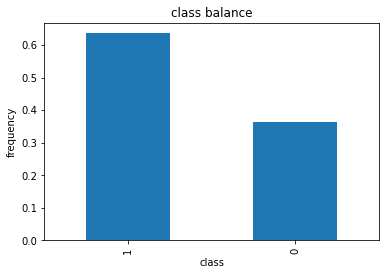

In [41]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",xlabel="class",ylabel="frequency",title="class balance"
)

**Task 4.2.8:** Create two variables, `majority_class_prop` and `minority_class_prop`, to store the normalized value counts for the two classes in `df["severe_damage"]`. 


In [42]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts()
print(majority_class_prop, minority_class_prop)

49661 28413


In [43]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6360760304326665 0.3639239695673336


**Task 4.2.9:** Are buildings with certain foundation types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"foundation_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [44]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df,index="foundation_type",values="severe_damage",aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.027134
Bamboo/Timber,0.321429
Cement-Stone/Brick,0.410200
Mud mortar-Stone/Brick,0.684101
Other,0.801020


**Task 4.2.10:** How do the proportions in `foundation_pivot` compare to the proportions for our majority and minority classes? Plot `foundation_pivot` as horizontal bar chart, adding vertical lines at the values for `majority_class_prop` and `minority_class_prop`.


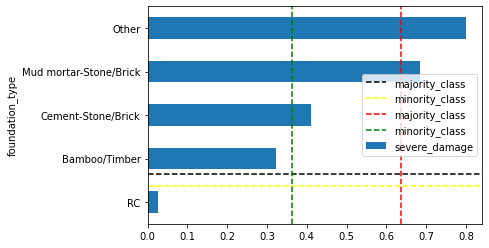

In [45]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh")
plt.axhline(majority_class_prop, linestyle="--",color="black",label="majority_class")
plt.axhline(minority_class_prop, linestyle="--",color="yellow",label="minority_class")
plt.axvline(majority_class_prop, linestyle="--",color="red",label="majority_class")
plt.axvline(minority_class_prop, linestyle="--",color="green",label="minority_class")
plt.legend(loc="center right")

**Task 4.2.11:** Combine the [`select_dtypes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) and [`nunique`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html) methods to see if there are any high- or low-cardinality categorical features in the dataset. 


In [46]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
dtype: int64

## Split

**Task 4.2.12:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 


In [47]:
target = "severe_damage"
X = df.drop(columns=target)
y = df[target]
y.head()

building_id
360101000011    1
360101000021    0
360101000031    0
360101000041    1
360101000051    1
Name: severe_damage, dtype: int32

In [48]:
X.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,...,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other
building_id,,,,,,,,,,,,,,,,,,,,,
360101000011,40,336,6,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,...,1,0,0,0,0,0,0,0,0,0
360101000021,12,420,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,1,0,0,0,0,0,0,0,0,0
360101000031,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,1,0,0,0,0,0,0,0,0,0
360101000041,15,390,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,...,1,0,0,0,0,0,0,0,0,0
360101000051,15,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Square,...,1,0,0,0,0,0,0,0,0,0


**Task 4.2.13:** Divide your data (`X` and `y`) into training and test sets using a randomized train-test split. Your test set should be 20% of your total data. And don't forget to set a `random_state` for reproducibility. 


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2 , random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (62459, 21)
y_train shape: (62459,)
X_test shape: (15615, 21)
y_test shape: (15615,)


# Build Model

## Baseline

**Task 4.2.14:** Calculate the baseline accuracy score for your model.


In [52]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


**Task 4.2.15:** Create a pipeline named `model` that contains a `OneHotEncoder` transformer and a `LogisticRegression` predictor. Be sure you set the `use_cat_names` argument for your transformer to `True`. Then fit it to the training data. 


In [53]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Evaluate

**Task 4.2.16:** Calculate the training and test accuracy scores for your models. 


In [54]:
acc_train = accuracy_score(y_train,model.predict(X_train))
acc_test = model.score(X_test,y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.72
Test Accuracy: 0.72


# Communicate

**Task 4.2.17:** Instead of using the `predict` method with your model, try `predict_proba` with your training data. How does the `predict_proba` output differ than that of `predict`? What does it represent?


In [55]:
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.28146758 0.71853242]
 [0.80737975 0.19262025]
 [0.2701782  0.7298218 ]
 [0.21606179 0.78393821]
 [0.11544684 0.88455316]]


**Task 4.2.18:** Extract the feature names and importances from your `model`.


In [57]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [64]:
features

['age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'land_surface_condition_Flat',
 'land_surface_condition_Steep slope',
 'land_surface_condition_Moderate slope',
 'foundation_type_Mud mortar-Stone/Brick',
 'foundation_type_Cement-Stone/Brick',
 'foundation_type_Bamboo/Timber',
 'foundation_type_RC',
 'foundation_type_Other',
 'roof_type_Bamboo/Timber-Heavy roof',
 'roof_type_Bamboo/Timber-Light roof',
 'roof_type_RCC/RB/RBC',
 'ground_floor_type_Mud',
 'ground_floor_type_Brick/Stone',
 'ground_floor_type_Timber',
 'ground_floor_type_RC',
 'ground_floor_type_Other',
 'other_floor_type_Not applicable',
 'other_floor_type_TImber/Bamboo-Mud',
 'other_floor_type_Timber-Planck',
 'other_floor_type_RCC/RB/RBC',
 'position_Not attached',
 'position_Attached-1 side',
 'position_Attached-2 side',
 'position_Attached-3 side',
 'plan_configuration_Rectangular',
 'plan_configuration_L-shape',
 'plan_configuration_Square',
 'plan_configuration_Multi-projected',
 'plan_configuration_T-shap

In [65]:
importances

array([ 6.38244692e-04,  1.59015125e-04,  7.40084576e-03, -3.59229127e-01,
        2.63310028e-01, -1.27196016e-01,  5.01322473e-01,  1.08100851e-01,
       -4.39586066e-01, -9.89716342e-01,  5.96763969e-01,  3.55773000e-01,
        2.16211925e-01, -7.95100039e-01, -1.22161220e-01,  9.96736827e-02,
        4.04110271e-01, -6.24787135e-01,  2.00492868e-02, -6.41726248e-02,
       -6.09149686e-02,  3.31155167e-01, -4.29182689e-01, -8.50400912e-02,
        6.75921253e-03, -7.03205475e-02, -7.45136884e-02,  3.30570314e-01,
       -2.87076962e-01,  1.60367392e-01, -3.16655375e-01,  3.89872918e-03,
       -8.35978375e-02, -2.67310280e-02, -6.06044524e-03, -9.26051019e-03,
        1.14306077e-02,  4.19861853e-02,  4.12530452e-01,  4.35013963e-01,
       -3.24718834e-01, -5.91383838e-01, -1.29264228e+00, -2.97591052e-01,
       -5.92803400e-01, -8.42765277e-01, -3.58181796e-01, -6.22066319e-01])

**Task 4.2.19:** Create a pandas Series named `odds_ratios`, where the index is `features` and the values are your the exponential of the `importances`. How does `odds_ratios` for this model look different from the other linear models we made in projects 2 and 3?

In [66]:
odds_ratios = pd.Series(np.exp(importances),index=features).sort_values()
odds_ratios

has_superstructure_cement_mortar_brick                0.274544
foundation_type_RC                                    0.371682
has_superstructure_rc_non_engineered                  0.430518
roof_type_RCC/RB/RBC                                  0.451536
ground_floor_type_RC                                  0.535375
has_superstructure_other                              0.536834
has_superstructure_bamboo                             0.552775
has_superstructure_mud_mortar_brick                   0.553561
foundation_type_Bamboo/Timber                         0.644303
other_floor_type_RCC/RB/RBC                           0.651041
land_surface_condition_Flat                           0.698214
has_superstructure_rc_engineered                      0.698946
has_superstructure_cement_mortar_stone                0.722731
plan_configuration_Multi-projected                    0.728582
has_superstructure_timber                             0.742605
plan_configuration_L-shape                            0

**Task 4.2.20:** Create a horizontal bar chart with the five largest coefficients from `odds_ratios`. Be sure to label your x-axis `"Odds Ratio"`.


Text(0.5, 0, 'Odds Ratio')

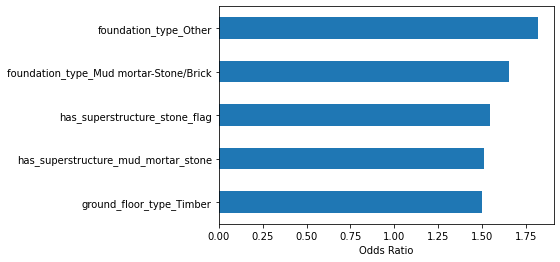

In [63]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio")

**Task 4.2.21:** Create a horizontal bar chart with the five smallest coefficients from `odds_ratios`. Be sure to label your x-axis `"Odds Ratio"`.


Text(0.5, 0, 'Odds Ratio')

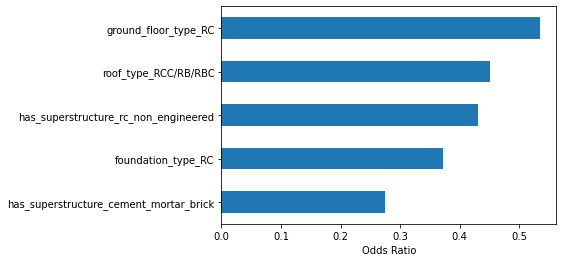

In [67]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio")